In [75]:
"""
Custom CNN Architecture for Kidney CT Classification
4-stage convolutional network trained from scratch
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

# Dynamic device selection: CUDA > MPS > CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
USE_CUDA = device.type == 'cuda'
USE_MPS = device.type == 'mps'

# CUDA-specific optimizations
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"Device: {device}")
if USE_CUDA:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif USE_MPS:
    print("Using Apple Silicon GPU (MPS)")

Device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti


In [ ]:
# Load dataset configuration
CONFIG_PATH = '../data/dataset_config.json'
assert os.path.exists(CONFIG_PATH), "Run 01_data_analysis_processing.ipynb first!"

with open(CONFIG_PATH) as f:
    config = json.load(f)

DATA_PATH = config['data_path']
MEAN, STD = config['mean'], config['std']
IMAGE_SIZE = config['image_size']

# Hyperparameters
OUTPUT_DIR = '../outputs/custom_cnn'
MODEL_PATH = os.path.join(OUTPUT_DIR, 'model.pth')
BATCH_SIZE = 128
EPOCHS = 40
LR = 1e-3
PATIENCE = 10
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(f"Data: {DATA_PATH}")
print(f"Normalization - Mean: {MEAN}, Std: {STD}")

Data: c:\Users\ELJOE\Desktop\project\data\processed
Normalization - Mean: [0.14509323239326477, 0.14509248733520508, 0.14509360492229462], Std: [0.2177080661058426, 0.21770790219306946, 0.21770821511745453]


In [77]:
# Fully cached dataset - all tensors in RAM, augmentation on tensors
class CachedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment=False):
        dataset = datasets.ImageFolder(root)
        self.augment = augment
        self.targets = []
        self.tensors = []
        
        print(f"Caching {len(dataset)} images as tensors...")
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])
        
        for path, target in tqdm(dataset.samples, desc="Loading"):
            img = Image.open(path).convert('RGB')
            tensor = transform(img)
            self.tensors.append(tensor)
            self.targets.append(target)
        
        # Stack into single tensor for faster indexing
        self.tensors = torch.stack(self.tensors)
        self.targets = torch.tensor(self.targets)
        self.classes = dataset.classes
        print(f"Cached tensor shape: {self.tensors.shape}")
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        x = self.tensors[idx]
        if self.augment:
            # Augment directly on tensors (fast)
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [2])  # Horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [1])  # Vertical flip (useful for CT)
        return x, self.targets[idx]

train_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'train'), augment=True)
val_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'val'), augment=False)
test_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'test'), augment=False)

# num_workers=0: Everything cached, no I/O needed
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                         num_workers=0, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"\nClasses: {class_names}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Caching 9411 images as tensors...


Loading: 100%|██████████| 9411/9411 [00:23<00:00, 407.95it/s]


Cached tensor shape: torch.Size([9411, 3, 224, 224])
Caching 2017 images as tensors...


Loading: 100%|██████████| 2017/2017 [00:04<00:00, 414.97it/s]


Cached tensor shape: torch.Size([2017, 3, 224, 224])
Caching 2017 images as tensors...


Loading: 100%|██████████| 2017/2017 [00:04<00:00, 421.77it/s]


Cached tensor shape: torch.Size([2017, 3, 224, 224])

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Train: 9411 | Val: 2017 | Test: 2017


In [78]:
class SimpleCNN(nn.Module):
    """
    4-stage CNN with progressive channel expansion.
    Architecture: 3→32→64→128→256 channels with spatial reduction at each stage.
    """
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.features = nn.Sequential(
            # Stage 1: 224→112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Stage 2: 112→56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Stage 3: 56→28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Stage 4: 28→14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        return self.classifier(x)

model = SimpleCNN(num_classes).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 390,404


In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader))

In [80]:
# Mixed precision training (CUDA only, MPS/CPU use float32)
scaler = torch.amp.GradScaler(device.type) if USE_CUDA else None
amp_dtype = torch.float16 if USE_CUDA else torch.float32

def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    
    for images, labels in tqdm(loader, desc='Train', leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad(set_to_none=True)
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        loss_sum += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    
    for images, labels in tqdm(loader, desc='Eval', leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss_sum += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return loss_sum / total, correct / total

# Warmup pass to initialize GPU kernels
_ = model(torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE, device=device))
if USE_CUDA:
    torch.cuda.synchronize()
elif USE_MPS:
    torch.mps.synchronize()
print("GPU initialized" if device.type != 'cpu' else "Running on CPU")

GPU initialized


In [81]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({'model_state_dict': model.state_dict(), 
                    'class_names': class_names, 'accuracy': best_acc}, MODEL_PATH)
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Best: {best_acc:.4f}")
    
    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}")

Epoch 01/40 | Train: 0.3983 | Val: 0.5791 | Best: 0.5791


Epoch 02/40 | Train: 0.5263 | Val: 0.6440 | Best: 0.6440


Epoch 03/40 | Train: 0.5765 | Val: 0.6822 | Best: 0.6822


Epoch 04/40 | Train: 0.6239 | Val: 0.7065 | Best: 0.7065


Epoch 05/40 | Train: 0.6512 | Val: 0.7080 | Best: 0.7080


Epoch 06/40 | Train: 0.6603 | Val: 0.7199 | Best: 0.7199


Epoch 07/40 | Train: 0.6688 | Val: 0.6931 | Best: 0.7199


Epoch 08/40 | Train: 0.6843 | Val: 0.7303 | Best: 0.7303


Epoch 09/40 | Train: 0.6921 | Val: 0.7318 | Best: 0.7318


Epoch 10/40 | Train: 0.7009 | Val: 0.7333 | Best: 0.7333


Epoch 11/40 | Train: 0.7071 | Val: 0.6792 | Best: 0.7333


Epoch 12/40 | Train: 0.7065 | Val: 0.7561 | Best: 0.7561


Epoch 13/40 | Train: 0.7107 | Val: 0.7184 | Best: 0.7561


Epoch 14/40 | Train: 0.7116 | Val: 0.6991 | Best: 0.7561


Epoch 15/40 | Train: 0.7174 | Val: 0.7189 | Best: 0.7561


Epoch 16/40 | Train: 0.7208 | Val: 0.7055 | Best: 0.7561


Epoch 17/40 | Train: 0.7285 | Val: 0.7372 | Best: 0.7561


Epoch 18/40 | Train: 0.7301 | Val: 0.7412 | Best: 0.7561


Epoch 19/40 | Train: 0.7356 | Val: 0.7625 | Best: 0.7625


Epoch 20/40 | Train: 0.7432 | Val: 0.7888 | Best: 0.7888


Epoch 21/40 | Train: 0.7500 | Val: 0.8052 | Best: 0.8052


Epoch 22/40 | Train: 0.7524 | Val: 0.7863 | Best: 0.8052


Epoch 23/40 | Train: 0.7658 | Val: 0.8052 | Best: 0.8052


Epoch 24/40 | Train: 0.7638 | Val: 0.8032 | Best: 0.8052


Epoch 25/40 | Train: 0.7689 | Val: 0.7714 | Best: 0.8052


Epoch 26/40 | Train: 0.7700 | Val: 0.8240 | Best: 0.8240


Epoch 27/40 | Train: 0.7730 | Val: 0.8275 | Best: 0.8275


Epoch 28/40 | Train: 0.7832 | Val: 0.8304 | Best: 0.8304


Epoch 29/40 | Train: 0.7802 | Val: 0.8235 | Best: 0.8304


Epoch 30/40 | Train: 0.7882 | Val: 0.8374 | Best: 0.8374


Epoch 31/40 | Train: 0.7914 | Val: 0.8379 | Best: 0.8379


Epoch 32/40 | Train: 0.7989 | Val: 0.8557 | Best: 0.8557


Epoch 33/40 | Train: 0.8008 | Val: 0.8513 | Best: 0.8557


Epoch 34/40 | Train: 0.7994 | Val: 0.8532 | Best: 0.8557


Epoch 35/40 | Train: 0.8016 | Val: 0.8532 | Best: 0.8557


Epoch 36/40 | Train: 0.8047 | Val: 0.8542 | Best: 0.8557


Epoch 37/40 | Train: 0.7989 | Val: 0.8592 | Best: 0.8592


Epoch 38/40 | Train: 0.8034 | Val: 0.8557 | Best: 0.8592


Epoch 39/40 | Train: 0.8095 | Val: 0.8562 | Best: 0.8592


Epoch 40/40 | Train: 0.8099 | Val: 0.8562 | Best: 0.8592

Training complete. Best validation accuracy: 0.8592


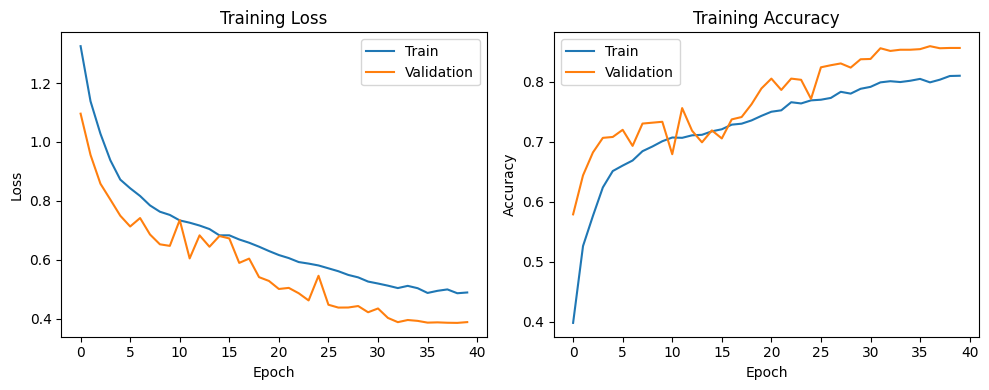

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training Loss')

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

## Test Set Evaluation

Final evaluation on held-out test set.

In [83]:
checkpoint = torch.load(MODEL_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model (validation accuracy: {checkpoint['accuracy']:.4f})")

Loaded best model (validation accuracy: 0.8592)


In [84]:
test_preds, test_labels_list = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device, non_blocking=True)
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            preds = model(images).argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.numpy())

print("\nTEST SET RESULTS")
print("=" * 50)
print(classification_report(test_labels_list, test_preds, target_names=class_names))

Testing: 100%|██████████| 8/8 [00:00<00:00, 19.68it/s]


TEST SET RESULTS
              precision    recall  f1-score   support

        Cyst       0.84      0.96      0.90       493
      Normal       0.90      0.88      0.89       750
       Stone       0.80      0.84      0.82       432
       Tumor       0.80      0.61      0.69       342

    accuracy                           0.85      2017
   macro avg       0.83      0.82      0.82      2017
weighted avg       0.85      0.85      0.84      2017



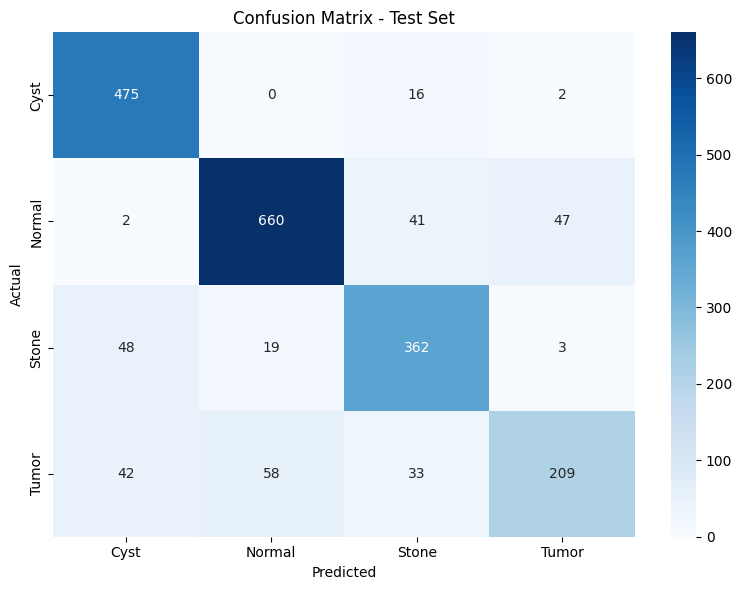

Test Accuracy: 0.8458


In [85]:
cm = confusion_matrix(test_labels_list, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

test_acc = (np.array(test_preds) == np.array(test_labels_list)).mean()
print(f"Test Accuracy: {test_acc:.4f}")

In [86]:
print("=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Model: Custom CNN ({total_params:,} parameters)")
print(f"Validation Accuracy: {best_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Saved: {MODEL_PATH}")

SUMMARY
Model: Custom CNN (390,404 parameters)
Validation Accuracy: 0.8592
Test Accuracy: 0.8458
Saved: ../outputs/custom_cnn\model.pth
